### Figure SI - Data analysis

**Author:** Quentin Duez

This notebook analyses ESI-MS data and extracts relative time delays and amplitudes of propagating perturbations for the experiment involving p-NO2 cinnamaldehyde.

**Outputs:** Figure S8

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

sns.set_theme(style="ticks", context="paper")

TIMEBIN = 15  # ~1bin = 30s
Ald_conc = 5  # mM
Cat_conc = 2  # mM
Cyclo_conc = 250  # mM

In [2]:
# Fitting functions


def sinfunc(t, A, w, p, c):
    return A * np.sin(np.pi * (t - p) / w) + c
    # return A * np.sin(w*t + p) + c


def fit_sin(
    tt, yy, PERIOD
):  # Scooped from https://stackoverflow.com/questions/16716302/how-do-i-fit-a-sine-curve-to-my-data-with-pylab-and-numpy
    '''Fit sin to the input time sequence, and return fitting parameters "amp", "omega", "phase", "offset", "freq", "period" and "fitfunc"'''
    tt = np.array(tt)
    yy = np.array(yy)
    ff = np.fft.fftfreq(len(tt), (tt[1] - tt[0]))  # assume uniform spacing
    Fyy = abs(np.fft.fft(yy))
    # guess_freq = 1./ PERIOD
    # excluding the zero frequency "peak", which is related to offset
    guess_amp = np.std(yy) * 2.0**0.5
    guess_offset = np.mean(yy)
    guess = np.array(
        [guess_amp, PERIOD / 2, 0.0, guess_offset]
    )  # Guess phase = 0; check what works better

    popt, pcov = curve_fit(
        sinfunc,
        tt,
        yy,
        p0=guess,
        bounds=(
            (0, (PERIOD - 0.0001) / 2, -np.inf, -np.inf),
            (np.inf, (PERIOD + 0.0001) / 2, np.inf, np.inf),
        ),
    )
    A, w, p, c = popt
    f = w / (2.0 * np.pi)
    period = w * 2
    fitfunc = lambda t: A * np.sin(np.pi * (t - p) / w) + c
    return {
        "amp": A,
        "omega": w,
        "phase": p,
        "offset": c,
        "freq": f,
        "period": period,
        "fitfunc": fitfunc,
        "maxcov": np.max(pcov),
        "rawres": (guess, popt, pcov),
    }


def fit_sin_CSTR(t, conc, eq_time, PERIOD):
    t_filtered = t[eq_time:]
    conc_filtered = conc[eq_time:]

    res = fit_sin(t_filtered, conc_filtered, PERIOD)
    ypred = sinfunc(t_filtered, res["amp"], res["omega"], res["phase"], res["offset"])
    r2 = r2_score(conc_filtered, ypred)
    # print(r2_score(conc_filtered, ypred))
    phase = res["phase"]
    amp = res["amp"]

    if abs(phase) > PERIOD:
        ntot = abs(phase) / PERIOD
        nunits = ntot // 1
        if nunits > 0:
            coma = ntot - nunits
        else:
            coma = 0
        phase = coma * PERIOD
    else:
        phase = phase

    if r2 > 0.2:  # Condition for not trying to interpret weird data
        rel_amp = (
            abs(res["amp"]) / res["offset"]
        )  # Calculate the amplitude of the oscillation relative to the ion signal

        # Get time delay from the phase (empirically determined, was tricky for me brain)
        if (res["amp"] > 0) & (phase > 0):
            delay = phase + 0.5 * res["omega"]
        elif (res["amp"] > 0) & (phase < 0):
            delay = phase + 2.5 * res["omega"]
        else:
            pass
    else:
        rel_amp = 0
        delay = 0
        phase = 0

    return (rel_amp, delay, r2, phase, amp)

In [3]:
# Reading flow profile
profile = pd.read_excel("data/250402_Iminium19.xlsx")
profile = profile.iloc[
    :, : profile.columns.get_loc("Concentration")
]  # Dropping everything after "Concentration"
profile = profile.iloc[
    :, profile.columns.get_loc("Flow") + 1 :
]  # Dropping everything before "Flow"
profile = profile.drop(columns=["Time"])
profile.set_index("Cumul. Time", inplace=True)
profile["Aldehyde_conc"] = (profile["Aldehyde"] * Ald_conc) / profile.sum(axis=1)
profile["Aldehyde_conc_rel"] = (
    profile["Aldehyde_conc"] / profile["Aldehyde_conc"].mean()
)
profile = profile.dropna()

profile.index = profile.index - 120

print(profile)

             Aldehyde     Cat     MeOH1     MeOH2     MeOH3  Aldehyde_conc  \
Cumul. Time                                                                  
-120.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-90.0        5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-89.9        5.826987  5.7666  5.746582  5.746582  5.746582       1.010460   
-89.8        5.887367  5.7666  5.726456  5.726456  5.726456       1.020931   
-89.7        5.947733  5.7666  5.706333  5.706333  5.706333       1.031399   
...               ...     ...       ...       ...       ...            ...   
 779.8       5.706213  5.7666  5.786840  5.786840  5.786840       0.989517   
 779.9       5.736406  5.7666  5.776776  5.776776  5.776776       0.994753   
 780.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
 870.0       5.766600  5.7666  5.766711  5.766711  5.766711       0.999988   
-120.0       5.766600  5.7666  5.766711  5.766711  5.766711     

In [4]:
# Reading data
data = pd.read_excel("data/250402_Iminium19_Data.xlsx", header=0)

data["200_TIC"] = data["IC_200"] / data["TIC"]
data["326_TIC"] = (
    data["IC_326"] / data["TIC"]
)  # 326 was saturating a bit, we will not use it
data["485_TIC"] = data["IC_485"] / data["TIC"]
data["551_TIC"] = data["IC_551"] / data["TIC"]
data["651_TIC"] = (
    data["IC_651"] / data["TIC"]
)  # 651 could be the product (although super low intensity)

bindata = data.groupby(data.index // TIMEBIN).mean()
bindata = bindata.drop(columns=["TIC"])
bindata.set_index("Time", inplace=True)

rolled_bindata = bindata.rolling(5, center=True).mean()

print(bindata)

                IC_200        IC_326        IC_485        IC_551  \
Time                                                               
0.4516    2.860000e+05  1.783013e+09  4.473639e+07  1.138802e+06   
1.2046    1.904015e+05  1.784866e+09  3.834653e+07  1.111659e+06   
1.9576    2.591763e+05  1.706853e+09  3.707449e+07  1.147940e+06   
2.7106    3.872803e+05  1.720206e+09  3.677348e+07  1.140329e+06   
3.4636    3.985543e+05  1.733165e+09  3.119464e+07  1.174433e+06   
...                ...           ...           ...           ...   
976.3396  1.095410e+06  9.013226e+08  4.443787e+07  6.506866e+06   
977.0926  1.483565e+06  8.340269e+08  3.945715e+07  8.382994e+06   
977.8456  1.291500e+06  8.234019e+08  4.626946e+07  6.442552e+06   
978.5986  1.311167e+06  9.602925e+08  4.764560e+07  7.354908e+06   
979.1006  1.388432e+06  8.863517e+08  4.267375e+07  1.029028e+07   

                IC_651   200_TIC   326_TIC   485_TIC   551_TIC   651_TIC  
Time                                    

In [5]:
data_2ndosci = bindata[(bindata.index > 120) & (bindata.index < 1100)]
data_2ndosci["200_TIC_rel"] = data_2ndosci["200_TIC"] / data_2ndosci["200_TIC"].mean()
data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
data_2ndosci["485_TIC_rel"] = data_2ndosci["485_TIC"] / data_2ndosci["485_TIC"].mean()
data_2ndosci["551_TIC_rel"] = data_2ndosci["551_TIC"] / data_2ndosci["551_TIC"].mean()
data_2ndosci["651_TIC_rel"] = data_2ndosci["651_TIC"] / data_2ndosci["651_TIC"].mean()
rolled_data_2ndosci = data_2ndosci.rolling(5, center=True).mean()
rolled_data_2ndosci = rolled_data_2ndosci.dropna()

data_2ndosci.index = data_2ndosci.index - 120
rolled_data_2ndosci.index = rolled_data_2ndosci.index - 120
profile_2ndosci = profile[(profile.index > 0) & (profile.index < 900)]

C:\Users\qduez\AppData\Local\Temp\ipykernel_5848\1892466139.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["200_TIC_rel"] = data_2ndosci["200_TIC"] / data_2ndosci["200_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_5848\1892466139.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_2ndosci["326_TIC_rel"] = data_2ndosci["326_TIC"] / data_2ndosci["326_TIC"].mean()
C:\Users\qduez\AppData\Local\Temp\ipykernel_5848\1892466139.py:4: SettingWithCopyWarning: 
A value is trying to be

200 (0.4225859921752654, 112.81571412871477, 0.6973473790608749)
485 (0.3917143255966684, 117.99999115298783, 0.4922068276888226)
551 (0.14230965060043185, 143.86483534160277, 0.34664534465134633)
651 (0, 0, 0.024476529376043943)


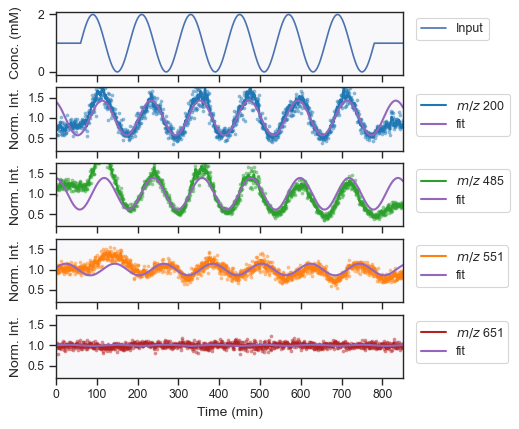

In [6]:
fig, ax = plt.subplots(5, 1, figsize=(7.3, 3.7))

sns.lineplot(
    data=profile, x=profile.index, y="Aldehyde_conc_rel", ax=ax[0], label="Input"
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="200_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[1],
    c="tab:blue",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="200_TIC_rel",
    ax=ax[1],
    linewidth=1.5,
    label=r"$\it{m/z}$ 200",
    c="tab:blue",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="485_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[2],
    c="tab:green",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="485_TIC_rel",
    ax=ax[2],
    linewidth=1.5,
    label=r"$\it{m/z}$ 485",
    c="tab:green",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="551_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[3],
    c="tab:orange",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="551_TIC_rel",
    ax=ax[3],
    linewidth=1.5,
    label=r"$\it{m/z}$ 551",
    c="tab:orange",
)
sns.scatterplot(
    data=data_2ndosci,
    x=data_2ndosci.index,
    y="651_TIC_rel",
    markers=["o"],
    alpha=0.5,
    s=7,
    linewidth=0,
    ax=ax[4],
    c="firebrick",
)
sns.lineplot(
    data=rolled_data_2ndosci,
    x=rolled_data_2ndosci.index,
    y="651_TIC_rel",
    ax=ax[4],
    linewidth=1.5,
    label=r"$\it{m/z}$ 651",
    c="firebrick",
)

ax[0].set_xlim(0, 850)
ax[1].set_xlim(0, 850)
ax[2].set_xlim(0, 850)
ax[3].set_xlim(0, 850)
ax[4].set_xlim(0, 850)
ax[1].set_ylim(0.2, 1.75)
ax[2].set_ylim(0.2, 1.75)
ax[3].set_ylim(0.2, 1.75)
ax[4].set_ylim(0.2, 1.75)

ax[0].set_ylabel("Conc. (mM)", fontsize=10)
ax[1].set_ylabel("Norm. Int.", fontsize=10)
ax[2].set_ylabel("Norm. Int.", fontsize=10)
ax[3].set_ylabel("Norm. Int.", fontsize=10)
ax[4].set_ylabel("Norm. Int.", fontsize=10)

ax[0].set_xlabel("")
ax[1].set_xlabel("")
ax[2].set_xlabel("")
ax[3].set_xlabel("")
ax[4].set_xlabel("Time (min)", fontsize=10)

ax[0].set_xticklabels("")
ax[1].set_xticklabels("")
ax[2].set_xticklabels("")
ax[3].set_xticklabels("")


fit_200 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["200_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_485 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["485_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_551 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["551_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time
fit_651 = fit_sin_CSTR(
    data_2ndosci.index.to_numpy(), data_2ndosci["651_TIC_rel"].to_numpy(), 50, 120
)  # 50 is 50 min offset time

pred_200 = sinfunc(data_2ndosci.index.to_numpy(), fit_200[4], 60, fit_200[3], 1)
pred_485 = sinfunc(data_2ndosci.index.to_numpy(), fit_485[4], 60, fit_485[3], 1)
pred_551 = sinfunc(data_2ndosci.index.to_numpy(), fit_551[4], 60, fit_551[3], 1)
pred_651 = sinfunc(data_2ndosci.index.to_numpy(), fit_651[4], 60, fit_651[3], 1)

# Uncomment to plot the fitted sinewaves
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_200,
    ax=ax[1],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_485,
    ax=ax[2],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_551,
    ax=ax[3],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)
sns.lineplot(
    x=data_2ndosci.index.to_numpy(),
    y=pred_651,
    ax=ax[4],
    linewidth=1.5,
    label="fit",
    c="tab:purple",
)

ax[0].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[1].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[2].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[3].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)
ax[4].legend(bbox_to_anchor=(1.02, 1.0), loc="upper left", fontsize=9)

ax[0].set_facecolor("#F8F8FB")
ax[1].set_facecolor("#F8F8FB")
ax[2].set_facecolor("#F8F8FB")
ax[3].set_facecolor("#F8F8FB")
ax[4].set_facecolor("#F8F8FB")

print("200", fit_200[0:3])
print("485", fit_485[0:3])
print("551", fit_551[0:3])
print("651", fit_651[0:3])

fig.align_ylabels(ax[:])

plt.subplots_adjust(left=None, bottom=None, right=0.6, top=1.1, wspace=None, hspace=0.2)
# plt.savefig('FigureSI_NO2.svg', format='svg', bbox_inches='tight', dpi=600)